### 对收集的数据的收集和简单处理完毕，接下来进行进一步处理和分析  
（收集和简单处理的代码，详见pa_wxx.ipynb）

> 文件与文件夹说明：
> - preprocessed: 预处理后的数据
> - raw: 仅将时间戳调整为不同地区的时间的几乎原始的数据
> - statistics: 统计与分析
> - ipynb文件为代码文件，目前主要为爬取和数据分析的代码，其中有较多注释


数据字典，目前为中文，以方便查看，后续会翻译成英文
- key: 观测站点的唯一标识符 - (str)
- class: 观测的类别 - (str)
- expire_time_gmt: 观测的过期时间 - (DATE)
- obs_id: 观测的ID - (str)
- obs_name: 观测站点的名称 - (str)
- valid_time_gmt: 观测的有效时间 - (DATE)
- day_ind: 一天中的时间段（白天或晚上） - (str)
- temp: 温度（华氏度） - (float)
- wx_icon: 天气图标的代码 - (int)
- icon_extd: 天气图标的扩展代码 - (int)
- wx_phrase: 天气短语描述 - (str)
- pressure_tend: 气压变化趋势 - (int, 0-稳定, 1-上升, 2-下降)
- pressure_desc: 气压描述 - (str, 其实就是前一字段的描述)
- dewPt: 露点温度（华氏度） - (float)
- heat_index: 酷热指数 - (float)
- rh: 相对湿度 - (float)
- pressure: 气压 - (float)
- vis: 能见度（英里） - (int, 0-10)
- wc: 风寒指数 - (float)
- wdir: 风向（角度） - (int, 以北, 顺时针的角度[10-360], 360代表北) 
- wdir_cardinal: 风向的助记符号 - (str, 描述风向, 比如N代表北风)
- gust: 风速瞬时值（英里/小时） - (float)
- wspd: 风速（英里/小时） - (float)
- max_temp: 最高温度（华氏度） - (float)
- min_temp: 最低温度（华氏度） - (float)
- precip_total: 总降水量（英寸） - (float)
- precip_hrly: 每小时降水量（英寸） - (float)
- snow_hrly: 每小时降雪量（英寸） - (float)
- uv_desc: 紫外线指数描述 - (str)
- feels_like: 体感温度（华氏度） - (float)
- uv_index: 紫外线指数 https://www.epa.gov/sunsafety/calculating-uv-index-0 - (float)

(以下列除了clds，都无数据，只是爬取时有该列，但是并没有数据)
- qualifier: 气象数据的限定条件
- qualifier_svrty: 限定条件的严重程度
- blunt_phrase: 概括的天气短语描述
- terse_phrase: 简短的天气短语描述
- clds: 云量 https://www.eoas.ubc.ca/courses/atsc113/flying/met_concepts/01-met_concepts/01c-cloud_coverage/index.html
- water_temp: 水温
- primary_wave_period: 主波周期
- primary_wave_height: 主波高度
- primary_swell_period: 主涌浪周期
- primary_swell_height: 主涌浪高度
- primary_swell_direction: 主涌浪方向
- secondary_swell_period: 次涌浪周期
- secondary_swell_height: 次涌浪高度
- secondary_swell_direction: 次涌浪方向

#### 1. 数据非空率、分布情况（词频率）、异常值比例

In [29]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from tqdm import tqdm

cities_ls = ['BAY','Chicago','DC','LA','Melbourne','NYC']
suffix = 'Weather_ori_1.csv'
# col = ['STATION', 'STATION_NAME', 'ELEVATION', 'LATITUDE', 'LONGITUDE', 'DATE', 'REPORTTYPE', 'HOURLYSKYCONDITIONS', 'HOURLYVISIBILITY', 'HOURLYPRSENTWEATHERTYPE', 'HOURLYDRYBULBTEMPF', 'HOURLYDRYBULBTEMPC', 'HOURLYWETBULBTEMPF', 'HOURLYWETBULBTEMPC', 'HOURLYDewPointTempF', 'HOURLYDewPointTempC', 'HOURLYRelativeHumidity', 'HOURLYWindSpeed', 'HOURLYWindDirection', 'HOURLYWindGustSpeed', 'HOURLYStationPressure', 'HOURLYPressureTendency', 'HOURLYPressureChange', 'HOURLYSeaLevelPressure', 'HOURLYPrecip', 'HOURLYAltimeterSetting', 'DAILYMaximumDryBulbTemp', 'DAILYMinimumDryBulbTemp', 'DAILYAverageDryBulbTemp', 'DAILYDeptFromNormalAverageTemp', 'DAILYAverageRelativeHumidity', 'DAILYAverageDewPointTemp', 'DAILYAverageWetBulbTemp', 'DAILYHeatingDegreeDays', 'DAILYCoolingDegreeDays', 'DAILYSunrise', 'DAILYSunset', 'DAILYWeather', 'DAILYPrecip', 'DAILYSnowfall', 'DAILYSnowDepth', 'DAILYAverageStationPressure', 'DAILYAverageSeaLevelPressure', 'DAILYAverageWindSpeed', 'DAILYPeakWindSpeed', 'PeakWindDirection', 'DAILYSustainedWindSpeed', 'DAILYSustainedWindDirection', 'MonthlyMaximumTemp', 'MonthlyMinimumTemp', 'MonthlyMeanTemp', 'MonthlyAverageRH', 'MonthlyDewpointTemp', 'MonthlyWetBulbTemp', 'MonthlyAvgHeatingDegreeDays', 'MonthlyAvgCoolingDegreeDays', 'MonthlyStationPressure', 'MonthlySeaLevelPressure', 'MonthlyAverageWindSpeed', 'MonthlyTotalSnowfall', 'MonthlyDeptFromNormalMaximumTemp', 'MonthlyDeptFromNormalMinimumTemp', 'MonthlyDeptFromNormalAverageTemp', 'MonthlyDeptFromNormalPrecip', 'MonthlyTotalLiquidPrecip', 'MonthlyGreatestPrecip', 'MonthlyGreatestPrecipDate', 'MonthlyGreatestSnowfall', 'MonthlyGreatestSnowfallDate', 'MonthlyGreatestSnowDepth', 'MonthlyGreatestSnowDepthDate', 'MonthlyDaysWithGT90Temp', 'MonthlyDaysWithLT32Temp', 'MonthlyDaysWithGT32Temp', 'MonthlyDaysWithLT0Temp', 'MonthlyDaysWithGT001Precip', 'MonthlyDaysWithGT010Precip', 'MonthlyDaysWithGT1Snow', 'MonthlyMaxSeaLevelPressureValue', 'MonthlyMaxSeaLevelPressureDate', 'MonthlyMaxSeaLevelPressureTime', 'MonthlyMinSeaLevelPressureValue', 'MonthlyMinSeaLevelPressureDate', 'MonthlyMinSeaLevelPressureTime', 'MonthlyTotalHeatingDegreeDays', 'MonthlyTotalCoolingDegreeDays', 'MonthlyDeptFromNormalHeatingDD', 'MonthlyDeptFromNormalCoolingDD', 'MonthlyTotalSeasonToDateHeatingDD', 'MonthlyTotalSeasonToDateCoolingDD']
col = ['key', 'class', 'expire_time_gmt', 'obs_id', 'obs_name', 'valid_time_gmt', 
         'day_ind', 'temp', 'wx_icon', 'icon_extd', 'wx_phrase', 'pressure_tend', 
         'pressure_desc', 'dewPt', 'heat_index', 'rh', 'pressure', 'vis', 'wc', 
         'wdir', 'wdir_cardinal', 'gust', 'wspd', 'max_temp', 'min_temp', 
         'precip_total', 'precip_hrly', 'snow_hrly', 'uv_desc', 'feels_like', 
         'uv_index', 'qualifier', 'qualifier_svrty', 'blunt_phrase', 'terse_phrase', 
         'clds', 'water_temp', 'primary_wave_period', 'primary_wave_height', 
         'primary_swell_period', 'primary_swell_height', 'primary_swell_direction', 
         'secondary_swell_period', 'secondary_swell_height', 'secondary_swell_direction']
# 适合分析和画图的列
draw_col = ['temp', 'wx_phrase', 'pressure_tend', 'pressure_desc',\
            'dewPt', 'heat_index', 'rh', 'pressure', 'vis', 'wc',\
            'wdir', 'wdir_cardinal', 'gust', 'wspd', 'max_temp',\
            'min_temp', 'precip_total', 'precip_hrly', 'snow_hrly',\
            'uv_desc', 'feels_like', 'uv_index', 'clds', ]

for c in cities_ls:
    f_str = c + suffix # the name of the file
    df_statistics = pd.read_csv(f_str)
    num_rows = len(df_statistics)
    print(c, "Number of rows:", num_rows)

    # 统计一下数据的非空率（即 1 减去 缺失率 ）
    prop_non_null_df = pd.DataFrame(columns=col)
    for col_name in col:
        prop_non_null = df_statistics[col_name].count() / num_rows
        prop_non_null_df.loc[0, col_name] = prop_non_null
        
    prop_non_null_path = f'./statistics/{c}/'
    prop_non_null_file = c+'Weather_ori_1_prop_non_null.csv'
    if not os.path.exists(prop_non_null_path):
        os.makedirs(prop_non_null_path)
    prop_non_null_df.to_csv(prop_non_null_path+prop_non_null_file,\
                          index=False)
    
    # 统计一下分布情况
    for col_name in draw_col:
        distribution = df_statistics[col_name].value_counts() / num_rows
        if len(distribution) == 0: continue
        distribution_path = f'./statistics/{c}/distribution/'
        if not os.path.exists(distribution_path):
            os.makedirs(distribution_path)
        distribution_file = c+f'Weather_ori_1_{col_name}.csv'
        distribution.to_csv(distribution_path+distribution_file)
        
        distribution.sort_index(inplace=True) # 先根据索引值排序
        # 区域图
        distribution.plot.area(x=distribution.index, stacked=False)

        # 折线图
        # distribution.plot.line()

        # 柱状图
        # distribution.plot.bar()

        plt.grid(color = 'r', linestyle = '--', linewidth = 0.5)
        if col_name == 'wx_phrase': plt.xticks(rotation=15)
        plt.savefig((distribution_path+distribution_file)[:-4], dpi=300)
        plt.close()



BAY Number of rows: 4849
Chicago Number of rows: 43734
DC Number of rows: 47368
LA Number of rows: 3197
Melbourne Number of rows: 240747
NYC Number of rows: 43431


##### 1.1 将所有城市的分布统计到同一张图里

In [30]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from tqdm import tqdm

cities_ls = ['BAY','Chicago','DC','LA','Melbourne','NYC']
suffix = 'Weather_ori_1.csv'
# col = ['STATION', 'STATION_NAME', 'ELEVATION', 'LATITUDE', 'LONGITUDE', 'DATE', 'REPORTTYPE', 'HOURLYSKYCONDITIONS', 'HOURLYVISIBILITY', 'HOURLYPRSENTWEATHERTYPE', 'HOURLYDRYBULBTEMPF', 'HOURLYDRYBULBTEMPC', 'HOURLYWETBULBTEMPF', 'HOURLYWETBULBTEMPC', 'HOURLYDewPointTempF', 'HOURLYDewPointTempC', 'HOURLYRelativeHumidity', 'HOURLYWindSpeed', 'HOURLYWindDirection', 'HOURLYWindGustSpeed', 'HOURLYStationPressure', 'HOURLYPressureTendency', 'HOURLYPressureChange', 'HOURLYSeaLevelPressure', 'HOURLYPrecip', 'HOURLYAltimeterSetting', 'DAILYMaximumDryBulbTemp', 'DAILYMinimumDryBulbTemp', 'DAILYAverageDryBulbTemp', 'DAILYDeptFromNormalAverageTemp', 'DAILYAverageRelativeHumidity', 'DAILYAverageDewPointTemp', 'DAILYAverageWetBulbTemp', 'DAILYHeatingDegreeDays', 'DAILYCoolingDegreeDays', 'DAILYSunrise', 'DAILYSunset', 'DAILYWeather', 'DAILYPrecip', 'DAILYSnowfall', 'DAILYSnowDepth', 'DAILYAverageStationPressure', 'DAILYAverageSeaLevelPressure', 'DAILYAverageWindSpeed', 'DAILYPeakWindSpeed', 'PeakWindDirection', 'DAILYSustainedWindSpeed', 'DAILYSustainedWindDirection', 'MonthlyMaximumTemp', 'MonthlyMinimumTemp', 'MonthlyMeanTemp', 'MonthlyAverageRH', 'MonthlyDewpointTemp', 'MonthlyWetBulbTemp', 'MonthlyAvgHeatingDegreeDays', 'MonthlyAvgCoolingDegreeDays', 'MonthlyStationPressure', 'MonthlySeaLevelPressure', 'MonthlyAverageWindSpeed', 'MonthlyTotalSnowfall', 'MonthlyDeptFromNormalMaximumTemp', 'MonthlyDeptFromNormalMinimumTemp', 'MonthlyDeptFromNormalAverageTemp', 'MonthlyDeptFromNormalPrecip', 'MonthlyTotalLiquidPrecip', 'MonthlyGreatestPrecip', 'MonthlyGreatestPrecipDate', 'MonthlyGreatestSnowfall', 'MonthlyGreatestSnowfallDate', 'MonthlyGreatestSnowDepth', 'MonthlyGreatestSnowDepthDate', 'MonthlyDaysWithGT90Temp', 'MonthlyDaysWithLT32Temp', 'MonthlyDaysWithGT32Temp', 'MonthlyDaysWithLT0Temp', 'MonthlyDaysWithGT001Precip', 'MonthlyDaysWithGT010Precip', 'MonthlyDaysWithGT1Snow', 'MonthlyMaxSeaLevelPressureValue', 'MonthlyMaxSeaLevelPressureDate', 'MonthlyMaxSeaLevelPressureTime', 'MonthlyMinSeaLevelPressureValue', 'MonthlyMinSeaLevelPressureDate', 'MonthlyMinSeaLevelPressureTime', 'MonthlyTotalHeatingDegreeDays', 'MonthlyTotalCoolingDegreeDays', 'MonthlyDeptFromNormalHeatingDD', 'MonthlyDeptFromNormalCoolingDD', 'MonthlyTotalSeasonToDateHeatingDD', 'MonthlyTotalSeasonToDateCoolingDD']
col = ['key', 'class', 'expire_time_gmt', 'obs_id', 'obs_name', 'valid_time_gmt', 
         'day_ind', 'temp', 'wx_icon', 'icon_extd', 'wx_phrase', 'pressure_tend', 
         'pressure_desc', 'dewPt', 'heat_index', 'rh', 'pressure', 'vis', 'wc', 
         'wdir', 'wdir_cardinal', 'gust', 'wspd', 'max_temp', 'min_temp', 
         'precip_total', 'precip_hrly', 'snow_hrly', 'uv_desc', 'feels_like', 
         'uv_index', 'qualifier', 'qualifier_svrty', 'blunt_phrase', 'terse_phrase', 
         'clds', 'water_temp', 'primary_wave_period', 'primary_wave_height', 
         'primary_swell_period', 'primary_swell_height', 'primary_swell_direction', 
         'secondary_swell_period', 'secondary_swell_height', 'secondary_swell_direction']
# 适合分析和画图的列
draw_col = ['temp', 'wx_phrase', 'pressure_tend', 'pressure_desc',\
            'dewPt', 'heat_index', 'rh', 'pressure', 'vis', 'wc',\
            'wdir', 'wdir_cardinal', 'gust', 'wspd', 'max_temp',\
            'min_temp', 'precip_total', 'precip_hrly', 'snow_hrly',\
            'uv_desc', 'feels_like', 'uv_index', 'clds', ]
# 以数据为主的列，以及可能出现异常值的列
number_col = ['temp', 'pressure_tend', 'dewPt', \
                'heat_index', 'rh', 'pressure', 'vis', 'wc',\
                'wdir', 'gust', 'wspd', 'max_temp',\
                'min_temp', 'precip_total', 'precip_hrly', 'snow_hrly',\
                'feels_like', 'uv_index', ]

# 将所有城市的分布统计到同一张图里
for col_name in tqdm(draw_col):
    distribution_path = f'./statistics/All_cities/distribution/'
    distribution_file = f'{col_name}.csv'
    tmp_ls = []
    num_cities = len(cities_ls)
    for c in cities_ls:
        f_str = c + suffix # the name of the file
        df_statistics = pd.read_csv(f_str)
        num_rows = len(df_statistics)
        distribution = df_statistics[col_name].value_counts() / num_rows
        distribution.sort_index(inplace=True) # 先根据索引值排序
        tmp_ls.append(distribution)

    plt.figure(figsize=(16,9), dpi=120)
    for i,c in enumerate(cities_ls):
        plt.subplot(math.ceil(num_cities/3), 3, i+1)
        d = tmp_ls[i]
        ax = d.plot.area(x=d.index, stacked=False)
        if col_name in number_col and len(d):
            sum = d.sum()
            now_sum = 0
            last_sum = 0
            index_ls = list(d.index)
            x_median = index_ls[0]  
            j = 0
            while(now_sum < sum/2):
                now_sum += d.iloc[j]
                if now_sum >= sum/2:
                    diff = now_sum - last_sum
                    oppo_diff = sum / 2 - last_sum
                    last_index = index_ls[j-1] if j>0 else 0
                    now_index = index_ls[j]
                    x_median = last_index + (now_index - last_index) * oppo_diff / diff
                    break
                last_sum = now_sum
                j+=1
            ax.axvline(x=x_median, color='red')
        plt.title(c)
    if not os.path.exists(distribution_path):
        os.makedirs(distribution_path)
    plt.suptitle(col_name, fontsize=26, weight = 'extra bold')
    plt.savefig((distribution_path+distribution_file)[:-4])
    plt.close()



100%|██████████| 23/23 [00:57<00:00,  2.49s/it]


#### 2. 异常值

In [32]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from openpyxl import Workbook

cities_ls = ['BAY','Chicago','DC','LA','Melbourne','NYC']
suffix = 'Weather_ori_1.csv'
# col = ['STATION', 'STATION_NAME', 'ELEVATION', 'LATITUDE', 'LONGITUDE', 'DATE', 'REPORTTYPE', 'HOURLYSKYCONDITIONS', 'HOURLYVISIBILITY', 'HOURLYPRSENTWEATHERTYPE', 'HOURLYDRYBULBTEMPF', 'HOURLYDRYBULBTEMPC', 'HOURLYWETBULBTEMPF', 'HOURLYWETBULBTEMPC', 'HOURLYDewPointTempF', 'HOURLYDewPointTempC', 'HOURLYRelativeHumidity', 'HOURLYWindSpeed', 'HOURLYWindDirection', 'HOURLYWindGustSpeed', 'HOURLYStationPressure', 'HOURLYPressureTendency', 'HOURLYPressureChange', 'HOURLYSeaLevelPressure', 'HOURLYPrecip', 'HOURLYAltimeterSetting', 'DAILYMaximumDryBulbTemp', 'DAILYMinimumDryBulbTemp', 'DAILYAverageDryBulbTemp', 'DAILYDeptFromNormalAverageTemp', 'DAILYAverageRelativeHumidity', 'DAILYAverageDewPointTemp', 'DAILYAverageWetBulbTemp', 'DAILYHeatingDegreeDays', 'DAILYCoolingDegreeDays', 'DAILYSunrise', 'DAILYSunset', 'DAILYWeather', 'DAILYPrecip', 'DAILYSnowfall', 'DAILYSnowDepth', 'DAILYAverageStationPressure', 'DAILYAverageSeaLevelPressure', 'DAILYAverageWindSpeed', 'DAILYPeakWindSpeed', 'PeakWindDirection', 'DAILYSustainedWindSpeed', 'DAILYSustainedWindDirection', 'MonthlyMaximumTemp', 'MonthlyMinimumTemp', 'MonthlyMeanTemp', 'MonthlyAverageRH', 'MonthlyDewpointTemp', 'MonthlyWetBulbTemp', 'MonthlyAvgHeatingDegreeDays', 'MonthlyAvgCoolingDegreeDays', 'MonthlyStationPressure', 'MonthlySeaLevelPressure', 'MonthlyAverageWindSpeed', 'MonthlyTotalSnowfall', 'MonthlyDeptFromNormalMaximumTemp', 'MonthlyDeptFromNormalMinimumTemp', 'MonthlyDeptFromNormalAverageTemp', 'MonthlyDeptFromNormalPrecip', 'MonthlyTotalLiquidPrecip', 'MonthlyGreatestPrecip', 'MonthlyGreatestPrecipDate', 'MonthlyGreatestSnowfall', 'MonthlyGreatestSnowfallDate', 'MonthlyGreatestSnowDepth', 'MonthlyGreatestSnowDepthDate', 'MonthlyDaysWithGT90Temp', 'MonthlyDaysWithLT32Temp', 'MonthlyDaysWithGT32Temp', 'MonthlyDaysWithLT0Temp', 'MonthlyDaysWithGT001Precip', 'MonthlyDaysWithGT010Precip', 'MonthlyDaysWithGT1Snow', 'MonthlyMaxSeaLevelPressureValue', 'MonthlyMaxSeaLevelPressureDate', 'MonthlyMaxSeaLevelPressureTime', 'MonthlyMinSeaLevelPressureValue', 'MonthlyMinSeaLevelPressureDate', 'MonthlyMinSeaLevelPressureTime', 'MonthlyTotalHeatingDegreeDays', 'MonthlyTotalCoolingDegreeDays', 'MonthlyDeptFromNormalHeatingDD', 'MonthlyDeptFromNormalCoolingDD', 'MonthlyTotalSeasonToDateHeatingDD', 'MonthlyTotalSeasonToDateCoolingDD']
col = ['key', 'class', 'expire_time_gmt', 'obs_id', 'obs_name', 'valid_time_gmt', 
         'day_ind', 'temp', 'wx_icon', 'icon_extd', 'wx_phrase', 'pressure_tend', 
         'pressure_desc', 'dewPt', 'heat_index', 'rh', 'pressure', 'vis', 'wc', 
         'wdir', 'wdir_cardinal', 'gust', 'wspd', 'max_temp', 'min_temp', 
         'precip_total', 'precip_hrly', 'snow_hrly', 'uv_desc', 'feels_like', 
         'uv_index', 'qualifier', 'qualifier_svrty', 'blunt_phrase', 'terse_phrase', 
         'clds', 'water_temp', 'primary_wave_period', 'primary_wave_height', 
         'primary_swell_period', 'primary_swell_height', 'primary_swell_direction', 
         'secondary_swell_period', 'secondary_swell_height', 'secondary_swell_direction']
# 适合分析和画图的列
draw_col = ['temp', 'wx_phrase', 'pressure_tend', 'pressure_desc',\
            'dewPt', 'heat_index', 'rh', 'pressure', 'vis', 'wc',\
            'wdir', 'wdir_cardinal', 'gust', 'wspd', 'max_temp',\
            'min_temp', 'precip_total', 'precip_hrly', 'snow_hrly',\
            'uv_desc', 'feels_like', 'uv_index', 'clds', ]


for c in cities_ls:
    f_str = c + suffix # the name of the file
    df_statistics = pd.read_csv(f_str)
    num_rows = len(df_statistics)
    print(c, "Number of rows:", num_rows)

    outlier_ratio_df = pd.DataFrame(columns=col) # 异常值比例
    # 以数据为主的列，以及可能出现异常值的列
    number_col = ['temp', 'pressure_tend', 'dewPt', \
                    'heat_index', 'rh', 'pressure', 'vis', 'wc',\
                    'wdir', 'gust', 'wspd', 'max_temp',\
                    'min_temp', 'precip_total', 'precip_hrly', 'snow_hrly',\
                    'feels_like', 'uv_index', ]
    df_2_list = [] # 超过2标准差的异常值列表
    df_3_list = [] # 超过3标准差的异常值列表

    for col_name in number_col:
        # 1. 统计异常值（大于两个标准差）比例
        data = df_statistics[col_name]
        if len(data) == 0: continue

        mean = data.mean()
        std = data.std()

        raw_out = (data - mean).abs() / std
        mask_2 = raw_out > 2 # 偏离均值大于两个标准差
        mask_3 = raw_out > 3 # 偏离均值大于三个标准差

        outlier_ratio_2 = mask_2.mean()
        outlier_ratio_3 = mask_3.mean()
        outlier_ratio_df.loc['std', col_name] = std
        outlier_ratio_df.loc['ratio_out_std_2', col_name] = outlier_ratio_2
        outlier_ratio_df.loc['ratio_out_std_3', col_name] = outlier_ratio_3

        # 2. 查找异常值
        dict_find_2 = {'valid_time_gmt':[], col_name:[], 'raw_out':[]} # 两个标准差
        dict_find_3 = {'valid_time_gmt':[], col_name:[], 'raw_out':[]} # 三个标准差
        data_find = df_statistics.loc[:, ['valid_time_gmt', col_name]]
        for i in range(len(mask_2)):
            if mask_2[i] == 1:
                dict_find_2['valid_time_gmt'].append(data_find.iloc[i, 0])
                dict_find_2[col_name].append(data_find.iloc[i, 1])
                dict_find_2['raw_out'].append(raw_out[i])
            if mask_3[i] == 1:
                dict_find_3['valid_time_gmt'].append(data_find.iloc[i, 0])
                dict_find_3[col_name].append(data_find.iloc[i, 1])
                dict_find_3['raw_out'].append(raw_out[i])
        outlier_value_2_df = pd.DataFrame(dict_find_2).sort_values(by=["raw_out", "valid_time_gmt"], ascending=[False, True])
        outlier_value_3_df = pd.DataFrame(dict_find_3).sort_values(by=["raw_out", "valid_time_gmt"], ascending=[False, True])
        df_2_list.append(outlier_value_2_df)
        df_3_list.append(outlier_value_3_df)

        outlier_value_path_2 = f'./statistics/{c}/outlier_value_2std/'  
        outlier_value_path_3 = f'./statistics/{c}/outlier_value_3std/'
        outlier_value_file = c+f'Weather_ori_1_{col_name}_outlier_value.csv'
        
        if not os.path.exists(outlier_value_path_2):
            os.makedirs(outlier_value_path_2)
        if not os.path.exists(outlier_value_path_3):
            os.makedirs(outlier_value_path_3)
        outlier_value_2_df.to_csv(outlier_value_path_2+outlier_value_file,\
                          index=False)
        outlier_value_3_df.to_csv(outlier_value_path_3+outlier_value_file,\
                          index=False)
    
    wb_2 = Workbook()
    wb_2.save(outlier_value_path_2+c+f'_ALL_Weather_ori_1_outlier_value.xlsx')
    wb_3 = Workbook()
    wb_3.save(outlier_value_path_3+c+f'_ALL_Weather_ori_1_outlier_value.xlsx')
    for df, col_name in zip(df_2_list,number_col):
        with pd.ExcelWriter(outlier_value_path_2+c+f'_ALL_Weather_ori_1_outlier_value.xlsx', engine='openpyxl', mode='a') as writer:
            writer.book = wb_2
            df.to_excel(writer, sheet_name=col_name)
    for df, col_name in zip(df_3_list,number_col):
        with pd.ExcelWriter(outlier_value_path_3+c+f'_ALL_Weather_ori_1_outlier_value.xlsx', engine='openpyxl', mode='a') as writer:
            writer.book = wb_3
            df.to_excel(writer, sheet_name=col_name)

    # writer_2 = pd.ExcelWriter(outlier_value_path_2+c+f'_ALL_Weather_ori_1_outlier_value.xlsx' ,mode='a',engine='openpyxl')
    # writer_3 = pd.ExcelWriter(outlier_value_path_3+c+f'_ALL_Weather_ori_1_outlier_value.xlsx' ,mode='a',engine='openpyxl')
    # for df, col_name in zip(df_2_list,number_col):
    #     df.to_excel(writer_2, col_name)
    # for df, col_name in zip(df_3_list,number_col):
    #     df.to_excel(writer_3, col_name)
    # writer_2.save()
    # writer_2.close()
    # writer_3.save()
    # writer_3.close()

    outlier_ratio_path = f'./statistics/{c}/'
    outlier_ratio_file = c+'Weather_ori_1_outlier_ratio.csv'
    if not os.path.exists(outlier_ratio_path):
        os.makedirs(outlier_ratio_path)
    outlier_ratio_df.to_csv(outlier_ratio_path+outlier_ratio_file,\
                          index=True)

outlier_ratio_df

BAY Number of rows: 4849
Chicago Number of rows: 43734
DC Number of rows: 47368
LA Number of rows: 3197
Melbourne Number of rows: 240747
NYC Number of rows: 43431


,key,class,expire_time_gmt,obs_id,obs_name,valid_time_gmt,day_ind,temp,wx_icon,icon_extd,...,clds,water_temp,primary_wave_period,primary_wave_height,primary_swell_period,primary_swell_height,primary_swell_direction,secondary_swell_period,secondary_swell_height,secondary_swell_direction
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.0196,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ratio_out_std_2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0212521,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ratio_out_std_3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.60501e-05,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### 3. 先对其进行处理，使每小时内的所有数据合并
（1）对于非数字的列（比如天气描述，为字符串），取第一次出现的  
（2）对于数字的列，若非‘最高气温’和‘最低气温’这两列，则取平均值  
（3）对于最高（最低）气温，取最大（最小）值  
（4）把expire_time替换成修改前的valid_time（valid_time即为观测的开始时间），再由（1），则处理后的expire_time，即为每小时的第一条数据的具体时间   


In [47]:
import os
import pandas as pd
from tqdm import tqdm

cities_ls = ['NYC', 'BAY','Chicago','DC','LA','Melbourne']
suffix = 'Weather_ori_1.csv'
# col = ['STATION', 'STATION_NAME', 'ELEVATION', 'LATITUDE', 'LONGITUDE', 'DATE', 'REPORTTYPE', 'HOURLYSKYCONDITIONS', 'HOURLYVISIBILITY', 'HOURLYPRSENTWEATHERTYPE', 'HOURLYDRYBULBTEMPF', 'HOURLYDRYBULBTEMPC', 'HOURLYWETBULBTEMPF', 'HOURLYWETBULBTEMPC', 'HOURLYDewPointTempF', 'HOURLYDewPointTempC', 'HOURLYRelativeHumidity', 'HOURLYWindSpeed', 'HOURLYWindDirection', 'HOURLYWindGustSpeed', 'HOURLYStationPressure', 'HOURLYPressureTendency', 'HOURLYPressureChange', 'HOURLYSeaLevelPressure', 'HOURLYPrecip', 'HOURLYAltimeterSetting', 'DAILYMaximumDryBulbTemp', 'DAILYMinimumDryBulbTemp', 'DAILYAverageDryBulbTemp', 'DAILYDeptFromNormalAverageTemp', 'DAILYAverageRelativeHumidity', 'DAILYAverageDewPointTemp', 'DAILYAverageWetBulbTemp', 'DAILYHeatingDegreeDays', 'DAILYCoolingDegreeDays', 'DAILYSunrise', 'DAILYSunset', 'DAILYWeather', 'DAILYPrecip', 'DAILYSnowfall', 'DAILYSnowDepth', 'DAILYAverageStationPressure', 'DAILYAverageSeaLevelPressure', 'DAILYAverageWindSpeed', 'DAILYPeakWindSpeed', 'PeakWindDirection', 'DAILYSustainedWindSpeed', 'DAILYSustainedWindDirection', 'MonthlyMaximumTemp', 'MonthlyMinimumTemp', 'MonthlyMeanTemp', 'MonthlyAverageRH', 'MonthlyDewpointTemp', 'MonthlyWetBulbTemp', 'MonthlyAvgHeatingDegreeDays', 'MonthlyAvgCoolingDegreeDays', 'MonthlyStationPressure', 'MonthlySeaLevelPressure', 'MonthlyAverageWindSpeed', 'MonthlyTotalSnowfall', 'MonthlyDeptFromNormalMaximumTemp', 'MonthlyDeptFromNormalMinimumTemp', 'MonthlyDeptFromNormalAverageTemp', 'MonthlyDeptFromNormalPrecip', 'MonthlyTotalLiquidPrecip', 'MonthlyGreatestPrecip', 'MonthlyGreatestPrecipDate', 'MonthlyGreatestSnowfall', 'MonthlyGreatestSnowfallDate', 'MonthlyGreatestSnowDepth', 'MonthlyGreatestSnowDepthDate', 'MonthlyDaysWithGT90Temp', 'MonthlyDaysWithLT32Temp', 'MonthlyDaysWithGT32Temp', 'MonthlyDaysWithLT0Temp', 'MonthlyDaysWithGT001Precip', 'MonthlyDaysWithGT010Precip', 'MonthlyDaysWithGT1Snow', 'MonthlyMaxSeaLevelPressureValue', 'MonthlyMaxSeaLevelPressureDate', 'MonthlyMaxSeaLevelPressureTime', 'MonthlyMinSeaLevelPressureValue', 'MonthlyMinSeaLevelPressureDate', 'MonthlyMinSeaLevelPressureTime', 'MonthlyTotalHeatingDegreeDays', 'MonthlyTotalCoolingDegreeDays', 'MonthlyDeptFromNormalHeatingDD', 'MonthlyDeptFromNormalCoolingDD', 'MonthlyTotalSeasonToDateHeatingDD', 'MonthlyTotalSeasonToDateCoolingDD']
col = ['key', 'class', 'expire_time_gmt', 'obs_id', 'obs_name', 'valid_time_gmt', 
         'day_ind', 'temp', 'wx_icon', 'icon_extd', 'wx_phrase', 'pressure_tend', 
         'pressure_desc', 'dewPt', 'heat_index', 'rh', 'pressure', 'vis', 'wc', 
         'wdir', 'wdir_cardinal', 'gust', 'wspd', 'max_temp', 'min_temp', 
         'precip_total', 'precip_hrly', 'snow_hrly', 'uv_desc', 'feels_like', 
         'uv_index', 'qualifier', 'qualifier_svrty', 'blunt_phrase', 'terse_phrase', 
         'clds', 'water_temp', 'primary_wave_period', 'primary_wave_height', 
         'primary_swell_period', 'primary_swell_height', 'primary_swell_direction', 
         'secondary_swell_period', 'secondary_swell_height', 'secondary_swell_direction']
number_col = ['temp', 'pressure_tend', 'dewPt', 'heat_index', 'rh',\
              'pressure', 'vis', 'wc', 'gust',\
              'wspd', 'precip_total', 'precip_hrly', 'snow_hrly',\
              'feels_like', 'uv_index']
special_col = ['max_temp','min_temp'] 
for c in cities_ls:
    f_str = c + suffix # the name of the file
    df_process = pd.read_csv(f_str)
    num_rows = len(df_process)
    print(c, "Number of rows:", num_rows)

    df_process['expire_time_gmt'] = df_process['valid_time_gmt'].copy()
    df_process['valid_time_gmt'] = df_process['valid_time_gmt'].apply(lambda x: str(x).split(':')[0])
    

    new_dict = {}
    for col_name in col:
        new_dict[col_name] = []
    last_date = 0
    tmp_dict = {}
    same_cnt = 0

    for i in tqdm(range(num_rows)):
        now_date = df_process.loc[i, 'valid_time_gmt']
        # DATE不相同，需要处理，其中前后边界需要特别处理
        if last_date != now_date:
            # 先把数据的列除以相同的行数，即转换为平均值
            for col_name in number_col:
                if i != 0: tmp_dict[col_name] /= same_cnt
            # 取最大or最小值
            if i != 0: tmp_dict['max_temp'] = max(tmp_dict['max_temp'])
            if i != 0: tmp_dict['min_temp'] = min(tmp_dict['min_temp'])
            # 然后把tmp_dict插入new_dict中
            for col_name in col:
                if i != 0 or i == num_rows-1: 
                    new_dict[col_name].append(tmp_dict[col_name])
            # 并初始化新的tmp_dict
            for col_name in col:
                tmp_dict[col_name] = df_process.loc[i, col_name]
            for col_name in number_col:
                tmp_dict[col_name] = float(tmp_dict[col_name])
            for col_name in special_col:
                tmp_dict[col_name] = [float(tmp_dict[col_name])]
                

            # 开始新的一轮相同DATE的行的处理，初始化↓
            same_cnt = 1
            last_date = now_date

        # DATE相同，加入到tmp_dict中
        else:
            # 计数加1
            same_cnt += 1
            # 直接加到tmo_dict（求和），最后再进行求平均值
            # 对于不在number_col中的列，其为字符串无法取平均值，只保留第一个的数据，即上方初始化的值
            for col_name in number_col:
                tmp_dict[col_name] += float(df_process.loc[i, col_name])
            # 对于最大值or最小值，先加入list中，后续再处理
            for col_name in special_col:
                tmp_dict[col_name].append(float(df_process.loc[i, col_name]))

            # 特殊处理尾端
            if i == num_rows-1:
                # 先转化为平均值
                for col_name in number_col:
                    tmp_dict[col_name] /= same_cnt
                # 取最大or最小值
                tmp_dict['max_temp'] = max(tmp_dict['max_temp'])
                tmp_dict['min_temp'] = min(tmp_dict['min_temp'])
                # 然后把tmp_dict插入new_dict中
                for col_name in col:
                    new_dict[col_name].append(tmp_dict[col_name])

    new_df = pd.DataFrame(new_dict)
    process_path = f'./preprocessed/step1/{c}/'
    process_file = c+'Weather_1h.csv'
    if not os.path.exists(process_path):
        os.makedirs(process_path)
    new_df.to_csv(process_path+process_file, index=False)

   

  1%|          | 398/43431 [00:00<00:10, 3976.03it/s]

NYC Number of rows: 43431


  8%|▊         | 412/4849 [00:00<00:01, 4118.85it/s]

BAY Number of rows: 4849


  1%|          | 378/43734 [00:00<00:11, 3743.86it/s]

Chicago Number of rows: 43734


  0%|          | 0/47368 [00:00<?, ?it/s]

DC Number of rows: 47368


  0%|          | 0/3197 [00:00<?, ?it/s]

LA Number of rows: 3197


  0%|          | 0/240747 [00:00<?, ?it/s]

Melbourne Number of rows: 240747


100%|██████████| 240747/240747 [00:45<00:00, 5320.09it/s]


#### 4. 处理一下wx_phrase列，使其字段少一些
比如合并partly cloudy、mostly cloudy统一为cloudy

##### 4.1 先打印出来，看一下有哪些字段

In [12]:
import os
import pandas as pd
from tqdm import tqdm

cities_ls = ['NYC', 'BAY','Chicago','DC','LA','Melbourne']
suffix = 'Weather_ori_1.csv'
dict = {}
for c in cities_ls:
    f_path = f'./preprocessed/step1/{c}/'
    f_file = c+'Weather_1h.csv' 
    f_str = f_path + f_file # the name of the file
    df_wx_phrase = list(pd.read_csv(f_str)['wx_phrase'].value_counts().index)
    num_rows = len(df_wx_phrase)
    print(c, "Number of types of wx_phrase:", num_rows)
    if num_rows == 0: continue
    print(df_wx_phrase[:5])
    dict[c] = df_wx_phrase



NYC Number of types of wx_phrase: 58
['Mostly Cloudy', 'Cloudy', 'Fair', 'Partly Cloudy', 'Light Rain']
BAY Number of types of wx_phrase: 19
['Fair', 'Mostly Cloudy', 'Cloudy', 'Partly Cloudy', 'Light Rain']
Chicago Number of types of wx_phrase: 57
['Cloudy', 'Fair', 'Mostly Cloudy', 'Partly Cloudy', 'Light Rain']
DC Number of types of wx_phrase: 49
['Cloudy', 'Mostly Cloudy', 'Fair', 'Partly Cloudy', 'Light Rain']
LA Number of types of wx_phrase: 6
['Fair', 'Cloudy', 'Mostly Cloudy', 'Partly Cloudy', 'Fair / Windy']
Melbourne Number of types of wx_phrase: 48
['Fair', 'Mostly Cloudy', 'Partly Cloudy', 'Fair / Windy', 'Mostly Cloudy / Windy']


##### 4.2 统计一下非重复的类别有哪些

In [13]:
new_dict = {}
big_ls = []
for c in cities_ls:
    tmp_ls = dict[c]
    new_ls = []
    for s in tmp_ls:
        s_ls = s.split(' / ')
        for t in s_ls:
            if t not in new_ls: new_ls.append(t)
            if t not in big_ls: big_ls.append(t)
    print(c, "Number of types of wx_phrase:", len(new_ls))
    if len(new_ls) == 0: continue
    print(new_ls[:5])
    new_dict[c] = new_ls

print(len(big_ls))
for s in big_ls:
    print('- ' + s)

NYC Number of types of wx_phrase: 34
['Mostly Cloudy', 'Cloudy', 'Fair', 'Partly Cloudy', 'Light Rain']
BAY Number of types of wx_phrase: 14
['Fair', 'Mostly Cloudy', 'Cloudy', 'Partly Cloudy', 'Light Rain']
Chicago Number of types of wx_phrase: 36
['Cloudy', 'Fair', 'Mostly Cloudy', 'Partly Cloudy', 'Light Rain']
DC Number of types of wx_phrase: 33
['Cloudy', 'Mostly Cloudy', 'Fair', 'Partly Cloudy', 'Light Rain']
LA Number of types of wx_phrase: 5
['Fair', 'Cloudy', 'Mostly Cloudy', 'Partly Cloudy', 'Windy']
Melbourne Number of types of wx_phrase: 33
['Fair', 'Mostly Cloudy', 'Partly Cloudy', 'Windy', 'Cloudy']
52
- Mostly Cloudy
- Cloudy
- Fair
- Partly Cloudy
- Light Rain
- Windy
- Fog
- Light Snow
- Rain
- Light Drizzle
- Haze
- Heavy Rain
- Light Rain with Thunder
- Thunder
- Snow
- Wintry Mix
- Heavy T-Storm
- T-Storm
- Drizzle and Fog
- Freezing Rain
- Rain and Snow
- Heavy Snow
- Thunder in the Vicinity
- Snow and Sleet
- Rain and Sleet
- Light Freezing Drizzle
- Light Freezin

##### 4.3 列出所有出现的wx_phrase字段，并对其进行转换使其更加精简

In [14]:
# 用于转换的字典
trans_dict = \
{
    'Cloudy': 'Cloudy',
    'Mostly Cloudy': 'Cloudy',
    'Fair': 'Fair',
    'Partly Cloudy': 'Cloudy',
    'Light Rain': 'Rainy',
    'Fog': 'Foggy',
    'Light Snow': 'Snowy',
    'Windy': 'Windy',
    'Rain': 'Rainy',
    'Light Drizzle': 'Rainy',
    'Heavy Rain': 'Rainy',
    'Haze': 'Overcast',
    'Light Rain with Thunder': 'Thunderstorm',
    'Snow': 'Snowy',
    'Heavy T-Storm': 'Thunderstorm',
    'Wintry Mix': 'Snowy',
    'Thunder': 'Thunderstorm',
    'T-Storm': 'Thunderstorm',
    'Drizzle and Fog': 'Foggy',
    'Freezing Rain': 'Rainy',
    'Thunder in the Vicinity': 'Thunderstorm',
    'Rain and Snow': 'Rainy / Snowy',
    'Heavy Snow': 'Snowy',
    'Rain and Sleet': 'Rainy',
    'Snow and Sleet': 'Snowy',
    'Light Freezing Rain': 'Rainy',
    'Light Freezing Drizzle': 'Rainy',
    'Light Snow and Sleet': 'Snowy',
    'Light Sleet': 'Snowy',
    'Patches of Fog': 'Foggy',
    'Mist': 'Foggy',
    'Sleet': 'Snowy',
    'Shallow Fog': 'Foggy',
    'Unknown Precipitation': 'Overcast',
    'Smoke': 'Overcast',
    'Drizzle': 'Rainy',
    'Blowing Snow': 'Snowy',
    'Funnel Cloud': 'Tornado',
    'Widespread Dust': 'Overcast',
    'Tornado': 'Tornado',
    'Thunder and Hail': 'Thunderstorm / Hail',
    'Heavy Sleet': 'Snowy',
    'Squalls': 'Thunderstorm',
    'Light Rain Shower': 'Rainy',
    'Showers in the Vicinity': 'Rainy',
    'Rain Shower': 'Rainy',
    'Heavy Rain Shower': 'Rainy',
    'Partial Fog': 'Foggy',
    'Heavy Drizzle': 'Rainy',
    'Thunder and Small Hail': 'Thunderstorm / Hail',
    'Low Drifting Dust': 'Overcast',
    'Small Hail': 'Hail',
    'Sand': 'Overcast',
    'Dust Whirlwinds': 'Overcast',
    'Hail': 'Hail'
}
error_ls = []
v_ls = []
for s in big_ls:
    if s not in trans_dict.keys():
        error_ls.append()
print(f'number of errors is {len(error_ls)}')
for v in trans_dict.values():
    if v not in v_ls: v_ls.append(v)
print(f'number of new types of wx_phrase is {len(v_ls)}')
for v in v_ls: print(v, end='  ')

number of errors is 0
number of new types of wx_phrase is 12
Cloudy  Fair  Rainy  Foggy  Snowy  Windy  Overcast  Thunderstorm  Rainy / Snowy  Tornado  Thunderstorm / Hail  Hail  

##### 4.4 one-hot编码替换原始的wx_phrase

In [22]:
import os
import pandas as pd
from tqdm import tqdm

all_type = ['Cloudy', 'Fair', 'Rainy', 'Foggy', 'Snowy',\
             'Windy', 'Overcast', 'Thunderstorm', 'Tornado', 'Hail']
cities_ls = ['NYC', 'BAY','Chicago','DC','LA','Melbourne']
suffix = 'Weather_ori_1.csv'
dict = {}
test_ls = ['Cloudy / Fair', 'Rain / Widespread Dust', 'Heavy Sleet / Thunder and Hail']
# special_ls = ['Rain and Snow', 'Thunder and Hail', 'Thunder and Small Hail']
def trans(x: str) -> str:
    if not isinstance(x, str): 
        # print(x)
        return '0000000000'
    tmp_ls = []
    tmp_str = ''
    tmp = x.split(' / ')
    for t in tmp:
        t = trans_dict[t] 
        if '/' in t:
            t = t.split(' / ')
            for t1 in t:
                tmp_ls.append(t1)
        else:
            tmp_ls.append(t)
    for type in all_type:
        tmp_str += '1' if type in tmp_ls else '0'
    return tmp_str
    # return tmp_str, tmp_ls

for test in test_ls:
    # tmp_str, tmp_ls = trans(test)
    # print(test + ':', tmp_str, tmp_ls)
    tmp_str = trans(test)
    print(test + ':', tmp_str)
    
for c in cities_ls:
    f_path = f'./preprocessed/step1/{c}/'
    f_file = c+'Weather_1h.csv' 
    f_str = f_path + f_file # the name of the file
    df_trans = pd.read_csv(f_str)
    num_rows = len(df_trans)
    print(c, "Number of rows:", num_rows)
    if num_rows == 0: continue
    df_trans['wx_phrase'] = df_trans['wx_phrase'].apply(trans)
    trans_path = f'./preprocessed/step2/{c}/'
    trans_file = c+'Weather_1h.csv'
    if not os.path.exists(trans_path):
        os.makedirs(trans_path)
    
    def date2str(date_str: str):
        from datetime import datetime
        import re
        ls = re.split(r'/| ', date_str)
        s = f'{ls[0]}{ls[1].zfill(2)}{ls[2].zfill(2)}{ls[3].zfill(2)}'
        return s

    df_trans['valid_time_gmt'] = df_trans['valid_time_gmt'].apply(date2str)

    df_trans.to_csv(trans_path+trans_file, index=False)
df_trans


Cloudy / Fair: 1100000000
Rain / Widespread Dust: 0010001000
Heavy Sleet / Thunder and Hail: 0000100101
NYC Number of rows: 37195
BAY Number of rows: 4357
Chicago Number of rows: 37191
DC Number of rows: 37124
LA Number of rows: 2878
Melbourne Number of rows: 112664


,key,class,expire_time_gmt,obs_id,obs_name,valid_time_gmt,day_ind,temp,wx_icon,icon_extd,...,clds,water_temp,primary_wave_period,primary_wave_height,primary_swell_period,primary_swell_height,primary_swell_direction,secondary_swell_period,secondary_swell_height,secondary_swell_direction
0,YMML,observation,2009/5/1 0:00,YMML,Melbourne/Tullam,2009050100,N,48.0,33.0,3300.0,...,CLR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,YMML,observation,2009/5/1 1:30,YMML,Melbourne/Tullam,2009050101,N,50.0,33.0,3390.0,...,CLR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,YMML,observation,2009/5/1 2:00,YMML,Melbourne/Tullam,2009050102,N,50.0,33.0,3390.0,...,CLR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,YMML,observation,2009/5/1 3:00,YMML,Melbourne/Tullam,2009050103,N,50.0,33.0,3390.0,...,CLR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,YMML,observation,2009/5/1 4:00,YMML,Melbourne/Tullam,2009050104,N,49.0,33.0,3390.0,...,CLR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112659,YMML,observation,2022/3/31 19:00,YMML,Melbourne,2022033119,D,63.5,30.0,3000.0,...,SCT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
112660,YMML,observation,2022/3/31 20:00,YMML,Melbourne,2022033120,N,61.0,29.0,2900.0,...,SCT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
112661,YMML,observation,2022/3/31 21:00,YMML,Melbourne,2022033121,N,59.0,33.0,3300.0,...,FEW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
112662,YMML,observation,2022/3/31 22:00,YMML,Melbourne,2022033122,N,57.0,27.0,2700.0,...,BKN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### 5.填补缺失数据

In [36]:
import os
import pandas as pd
from tqdm import tqdm
import datetime
import calendar

col = ['key', 'class', 'expire_time_gmt', 'obs_id', 'obs_name', 'valid_time_gmt', 
         'day_ind', 'temp', 'wx_icon', 'icon_extd', 'wx_phrase', 'pressure_tend', 
         'pressure_desc', 'dewPt', 'heat_index', 'rh', 'pressure', 'vis', 'wc', 
         'wdir', 'wdir_cardinal', 'gust', 'wspd', 'max_temp', 'min_temp', 
         'precip_total', 'precip_hrly', 'snow_hrly', 'uv_desc', 'feels_like', 
         'uv_index', 'qualifier', 'qualifier_svrty', 'blunt_phrase', 'terse_phrase', 
         'clds', 'water_temp', 'primary_wave_period', 'primary_wave_height', 
         'primary_swell_period', 'primary_swell_height', 'primary_swell_direction', 
         'secondary_swell_period', 'secondary_swell_height', 'secondary_swell_direction']
all_type = ['Cloudy', 'Fair', 'Rainy', 'Foggy', 'Snowy',\
             'Windy', 'Overcast', 'Thunderstorm', 'Tornado', 'Hail']
cities_ls = ['NYC', 'BAY','Chicago','DC','LA','Melbourne']
suffix = 'Weather_ori_1.csv'
dict = {}
    
for c in cities_ls:
    f_path = f'./preprocessed/step2/{c}/'
    f_file = c+'Weather_1h.csv' 
    f_str = f_path + f_file # the name of the file
    df_for_fill = pd.read_csv(f_str, converters={'wx_phrase':str})
    num_rows = len(df_for_fill)
    print_msg = str(c+" Number of rows: ").ljust(30)+str(num_rows)
    print(print_msg.ljust(50), end='')
    if num_rows == 0: continue

    def str2date(s:str)->datetime.datetime:
        """s: s must like '2023051102', its first four letters represent year, 
        and then each 2 letters represent month, day, hour respectively"""
        s = str(s)
        year, month, day, hour = s[:4], s[4:6], s[6:8], s[8:]
        return datetime.datetime(int(year), int(month), int(day), int(hour))
    def date2str(date:datetime.datetime)->str:
        # {ls[0]}{ls[1].zfill(2)}{ls[2].zfill(2)}{ls[3].zfill(2)}
        return f'{str(date.year)}{str(date.month).zfill(2)}{str(date.day).zfill(2)}{str(date.hour).zfill(2)}'

    start_str = df_for_fill.loc[0, 'valid_time_gmt']
    # print(start_str)
    end_str = df_for_fill.loc[num_rows-1, 'valid_time_gmt']
    start_date = str2date(start_str)
    end_date = str2date(end_str)
    now_date = start_date
    cnt = 0 # 用于索引csv的行
    dict_for_df = {} # 用于构建新的df
    ls_filled = [] # 用于记录哪些时刻原本是没有的而是被新填充的
    for col_name in col:
        dict_for_df[col_name] = []
    while now_date <= end_date:
        csv_str = df_for_fill.loc[cnt, 'valid_time_gmt']
        csv_date = str2date(csv_str)
        if csv_date == now_date:
            tmp_row = df_for_fill.loc[cnt].copy() # 不需要填充
            for col_name in col:
                dict_for_df[col_name].append(tmp_row[col_name])
        else:
            tmp_row = df_for_fill.loc[cnt-1].copy() # 取上一时刻的来填充
            tmp_str = date2str(now_date)
            tmp_row['valid_time_gmt'] = tmp_str # 修改时间
            ls_filled.append(tmp_str)
            for col_name in col:
                dict_for_df[col_name].append(tmp_row[col_name])

            cnt -= 1 # 这个是为了防止跳过当前的行
        now_date += datetime.timedelta(hours=1)
        cnt += 1

    df_filled = pd.DataFrame(dict_for_df) # 生成新的dataframe
    df_record = pd.DataFrame(ls_filled) # 记录哪些时刻是被新填充的
    filled_path = f'./preprocessed/step3/{c}/'
    filled_file = c+'Weather_1h.csv'
    record_file = c+'record.csv'

    if not os.path.exists(filled_path):
        os.makedirs(filled_path)

    df_filled.to_csv(filled_path+filled_file, index=False)
    df_record.to_csv(filled_path+record_file, index=False)
    print(f'after filled: {len(df_filled)}')
df_filled


NYC Number of rows:           37195               after filled: 37273
BAY Number of rows:           4357                after filled: 4367
Chicago Number of rows:       37191               after filled: 37272
DC Number of rows:            37124               after filled: 37272
LA Number of rows:            2878                after filled: 2879
Melbourne Number of rows:     112664              after filled: 113232


,key,class,expire_time_gmt,obs_id,obs_name,valid_time_gmt,day_ind,temp,wx_icon,icon_extd,...,clds,water_temp,primary_wave_period,primary_wave_height,primary_swell_period,primary_swell_height,primary_swell_direction,secondary_swell_period,secondary_swell_height,secondary_swell_direction
0,YMML,observation,2009/5/1 0:00,YMML,Melbourne/Tullam,2009050100,N,48.0,33.0,3300.0,...,CLR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,YMML,observation,2009/5/1 1:30,YMML,Melbourne/Tullam,2009050101,N,50.0,33.0,3390.0,...,CLR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,YMML,observation,2009/5/1 2:00,YMML,Melbourne/Tullam,2009050102,N,50.0,33.0,3390.0,...,CLR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,YMML,observation,2009/5/1 3:00,YMML,Melbourne/Tullam,2009050103,N,50.0,33.0,3390.0,...,CLR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,YMML,observation,2009/5/1 4:00,YMML,Melbourne/Tullam,2009050104,N,49.0,33.0,3390.0,...,CLR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113227,YMML,observation,2022/3/31 19:00,YMML,Melbourne,2022033119,D,63.5,30.0,3000.0,...,SCT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
113228,YMML,observation,2022/3/31 20:00,YMML,Melbourne,2022033120,N,61.0,29.0,2900.0,...,SCT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
113229,YMML,observation,2022/3/31 21:00,YMML,Melbourne,2022033121,N,59.0,33.0,3300.0,...,FEW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
113230,YMML,observation,2022/3/31 22:00,YMML,Melbourne,2022033122,N,57.0,27.0,2700.0,...,BKN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### 6. 构建场景

##### 6.1. 分析一下总的各类天气的出现频率

In [1]:
import os
import pandas as pd
from tqdm import tqdm
import datetime
import calendar

col = ['key', 'class', 'expire_time_gmt', 'obs_id', 'obs_name', 'valid_time_gmt', 
         'day_ind', 'temp', 'wx_icon', 'icon_extd', 'wx_phrase', 'pressure_tend', 
         'pressure_desc', 'dewPt', 'heat_index', 'rh', 'pressure', 'vis', 'wc', 
         'wdir', 'wdir_cardinal', 'gust', 'wspd', 'max_temp', 'min_temp', 
         'precip_total', 'precip_hrly', 'snow_hrly', 'uv_desc', 'feels_like', 
         'uv_index', 'qualifier', 'qualifier_svrty', 'blunt_phrase', 'terse_phrase', 
         'clds', 'water_temp', 'primary_wave_period', 'primary_wave_height', 
         'primary_swell_period', 'primary_swell_height', 'primary_swell_direction', 
         'secondary_swell_period', 'secondary_swell_height', 'secondary_swell_direction']
all_type = ['Cloudy', 'Fair', 'Rainy', 'Foggy', 'Snowy',\
             'Windy', 'Overcast', 'Thunderstorm', 'Tornado', 'Hail']
cities_ls = ['NYC', 'BAY','Chicago','DC','LA','Melbourne']
suffix = 'Weather_ori_1.csv'
dict = {}
    
for index in range(len(all_type)):
    print('-'*40)
    print(all_type[index])
    for c in cities_ls:
        f_path = f'./preprocessed/step3/{c}/'
        f_file = c+'Weather_1h.csv' 
        f_str = f_path + f_file # the name of the file
        df_for_rain = pd.read_csv(f_str, converters={'wx_phrase':str})
        num_rows = len(df_for_rain)
        print_msg = str(c+" Number of rows: ").ljust(30)+str(num_rows)
        print(print_msg.ljust(50), end='')
        if num_rows == 0: continue

        # 先按照7:1:2把原数据分成三个部分，统计下各部分雨天的比例
        cnt1 = 0 # 7
        cnt2 = 0 # 1
        cnt3 = 0 # 2

        for i in range(num_rows):
            wx_phrase = str(df_for_rain.loc[i, 'wx_phrase'])
            if wx_phrase[index] == '1' or\
                (index == 2 and float(df_for_rain.loc[i, 'precip_hrly']) > 0) or\
                (index == 4 and float(df_for_rain.loc[i, 'snow_hrly']) > 0) or\
                (index == 0 and str(df_for_rain.loc[i, 'clds']) in ['SCT','BKN','OVC']):
                if i < num_rows*7/10: cnt1 += 1
                if i >= num_rows*7/10 and i <num_rows*8/10: cnt2 += 1
                if i >= num_rows*8/10: cnt3 += 1
        print(f'{cnt1}'.ljust(10)+f'{cnt2}'.ljust(10)+f'{cnt3}'.ljust(10), f'{all_type[index]} ratio of all: {(cnt1+cnt2+cnt3)/num_rows:.4f}')



----------------------------------------
Cloudy
NYC Number of rows:           37273               20523     2714      5851       Cloudy ratio of all: 0.7804
BAY Number of rows:           4367                2241      208       376        Cloudy ratio of all: 0.6469
Chicago Number of rows:       37272               20045     2612      5618       Cloudy ratio of all: 0.7586
DC Number of rows:            37272               21132     2719      6067       Cloudy ratio of all: 0.8027
LA Number of rows:            2879                607       80        144        Cloudy ratio of all: 0.2886
Melbourne Number of rows:     113232              42053     5503      11779      Cloudy ratio of all: 0.5240
----------------------------------------
Fair
NYC Number of rows:           37273               5556      1011      1601       Fair ratio of all: 0.2191
BAY Number of rows:           4367                814       229       497        Fair ratio of all: 0.3526
Chicago Number of rows:       37272   

##### 6.2 滑动窗口分析

In [2]:
import os
import pandas as pd
from tqdm import tqdm
import datetime
import calendar
import matplotlib.pyplot as plt
import seaborn as sns

col = ['key', 'class', 'expire_time_gmt', 'obs_id', 'obs_name', 'valid_time_gmt', 
         'day_ind', 'temp', 'wx_icon', 'icon_extd', 'wx_phrase', 'pressure_tend', 
         'pressure_desc', 'dewPt', 'heat_index', 'rh', 'pressure', 'vis', 'wc', 
         'wdir', 'wdir_cardinal', 'gust', 'wspd', 'max_temp', 'min_temp', 
         'precip_total', 'precip_hrly', 'snow_hrly', 'uv_desc', 'feels_like', 
         'uv_index', 'qualifier', 'qualifier_svrty', 'blunt_phrase', 'terse_phrase', 
         'clds', 'water_temp', 'primary_wave_period', 'primary_wave_height', 
         'primary_swell_period', 'primary_swell_height', 'primary_swell_direction', 
         'secondary_swell_period', 'secondary_swell_height', 'secondary_swell_direction']
all_type = ['Cloudy', 'Fair', 'Rainy', 'Foggy', 'Snowy',\
             'Windy', 'Overcast', 'Thunderstorm', 'Tornado', 'Hail']
cities_ls = ['NYC', 'BAY','Chicago','DC','LA','Melbourne']
suffix = 'Weather_ori_1.csv'
dict = {}
window_size = 200 * 24 # 目前构建train、val、test总共200天的场景 
window_step = 10 * 24 # 目前设置窗口每次滑动10天
    

for c in cities_ls:
    # BAY Number of rows: 4367
    # LA Number of rows:  2879
    # BAY 和 LA 数据集小，构建场景也因此窗口大小需要小一些
    if c in ['BAY','LA']:
        window_size = 100 * 24 # 100天
        window_step = 5 * 24 # 5天
    else:
        window_size = 200 * 24 # 目前构建train、val、test总共200天的场景 
        window_step = 10 * 24 # 目前设置窗口每次滑动10天
    f_path = f'./preprocessed/step3/{c}/'
    f_file = c+'Weather_1h.csv' 
    f_str = f_path + f_file # the name of the file
    df_for_window = pd.read_csv(f_str, converters={'wx_phrase':str})
    num_rows = len(df_for_window)
    print_msg = str(c+" Number of rows: ").ljust(30)+str(num_rows)
    print(print_msg.ljust(50), end='\n')
    if num_rows == 0: continue

    now_index = 0 
    window_cnt = 0 # 记录窗口滑动次数
    cnt_max = 1000 # 滑动次数阈值，目前置为1000，能覆盖近30年，当滑动次数大于cnt_max时，停止循环
    while now_index + window_size <= num_rows and window_cnt < cnt_max: 
        cnt = {} # 用于计数train, val, test中各类天气的出现频次
        # 初始化
        # cnt['vis'] = [0,0,0]
        for index in range(len(all_type)-2): # -2是不考虑最后的tornado和hail，因它们出现过少
            cnt[all_type[index]] = [0,0,0] 
        for i in range(window_size):
            j = now_index + i 
            # if j >= num_rows: break
            wx_phrase = str(df_for_window.loc[j, 'wx_phrase'])
            # vis = float(df_for_window.loc[j, 'vis']) if df_for_window.loc[j, 'vis'] >= 0 else 0
            # if i < window_size*7/10: cnt['vis'][0] += vis
            # if i >= window_size*7/10 and i <window_size*9/10: cnt['vis'][1] += vis
            # if i >= window_size*9/10: cnt['vis'][2] += vis
            for index in range(len(all_type)-2): # -2是不考虑最后的tornado和hail，因它们出现过少
                if wx_phrase[index] == '1' or\
                    (index == 2 and float(df_for_window.loc[j, 'precip_hrly']) > 0) or\
                    (index == 4 and float(df_for_window.loc[j, 'snow_hrly']) > 0) or\
                    (index == 0 and str(df_for_window.loc[j, 'clds']) in ['SCT','BKN','OVC']):
                    if i < window_size*7/10: cnt[all_type[index]][0] += 1
                    if i >= window_size*7/10 and i <window_size*8/10: cnt[all_type[index]][1] += 1
                    if i >= window_size*8/10: cnt[all_type[index]][2] += 1
        cnt_df = pd.DataFrame(cnt, index=['Training', 'Validatation', 'Test'])
        cnt_df.loc['Training'] /= window_size*7/10
        cnt_df.loc['Validatation'] /= window_size*1/10
        cnt_df.loc['Test'] /= window_size*2/10

        
        cnt_df.plot.bar(figsize=(16,9))

        plt.xticks(rotation=0, fontsize = 'xx-large')
        plt.title(f"{c} ({df_for_window.loc[now_index, 'valid_time_gmt']} - {df_for_window.loc[now_index+window_size, 'valid_time_gmt']})", fontsize=32)
        # plt.show()
        png_path = f'./scene/general/{c}/'
        png_file = f"{c} ({df_for_window.loc[now_index, 'valid_time_gmt']} - {df_for_window.loc[now_index+window_size, 'valid_time_gmt']})"
        if not os.path.exists(png_path):
            os.makedirs(png_path)
        plt.savefig(png_path+png_file, dpi=120)
        plt.close()

        now_index += window_step
        window_cnt += 1
cnt_df

# cnt_df.plot(figsize=(16,9))

# cnt_df.plot.bar(figsize=(16,9))

# plt.xticks(rotation=0)
# # plt.show()
# plt.savefig('./tmp.png', dpi=120)
# plt.close()


NYC Number of rows:           37273               
BAY Number of rows:           4367                
Chicago Number of rows:       37272               
DC Number of rows:            37272               
LA Number of rows:            2879                
Melbourne Number of rows:     113232              


,Cloudy,Fair,Rainy,Foggy,Snowy,Windy,Overcast,Thunderstorm
Training,0.510714,0.480952,0.113988,0.001488,0.0,0.090476,0.0,0.005655
Validatation,0.404167,0.585417,0.091667,0.000000,0.0,0.075000,0.0,0.018750
Test,0.504167,0.483333,0.083333,0.004167,0.0,0.047917,0.0,0.001042


##### 6.2 季节变迁
需要把窗口调小，考虑为调成100天

In [13]:
import os
import pandas as pd
from tqdm import tqdm
import datetime
import calendar
import matplotlib.pyplot as plt
import seaborn as sns

col = ['key', 'class', 'expire_time_gmt', 'obs_id', 'obs_name', 'valid_time_gmt', 
         'day_ind', 'temp', 'wx_icon', 'icon_extd', 'wx_phrase', 'pressure_tend', 
         'pressure_desc', 'dewPt', 'heat_index', 'rh', 'pressure', 'vis', 'wc', 
         'wdir', 'wdir_cardinal', 'gust', 'wspd', 'max_temp', 'min_temp', 
         'precip_total', 'precip_hrly', 'snow_hrly', 'uv_desc', 'feels_like', 
         'uv_index', 'qualifier', 'qualifier_svrty', 'blunt_phrase', 'terse_phrase', 
         'clds', 'water_temp', 'primary_wave_period', 'primary_wave_height', 
         'primary_swell_period', 'primary_swell_height', 'primary_swell_direction', 
         'secondary_swell_period', 'secondary_swell_height', 'secondary_swell_direction']
all_type = ['Cloudy', 'Fair', 'Rainy', 'Foggy', 'Snowy',\
             'Windy', 'Overcast', 'Thunderstorm', 'Tornado', 'Hail']
cities_ls = ['NYC', 'BAY','Chicago','DC','LA','Melbourne']
suffix = 'Weather_ori_1.csv'
dict = {}
window_size = 100 * 24 # 目前构建train、val、test总共100天的场景 
window_step = 5 * 24 # 目前设置窗口每次滑动5天
    

for c in cities_ls:
    # BAY Number of rows: 4367
    # LA Number of rows:  2879
    # BAY 和 LA 数据集小，构建场景也因此窗口大小需要小一些
    if c in ['BAY','LA']:
        window_size = 60 * 24 # 100天
        window_step = 3 * 24 # 5天
    else:
        window_size = 100 * 24 # 目前构建train、val、test总共100天的场景 
        window_step = 5 * 24 # 目前设置窗口每次滑动5天
    f_path = f'./preprocessed/step3/{c}/'
    f_file = c+'Weather_1h.csv' 
    f_str = f_path + f_file # the name of the file
    df_for_window = pd.read_csv(f_str, converters={'wx_phrase':str})
    num_rows = len(df_for_window)
    print_msg = str(c+" Number of rows: ").ljust(30)+str(num_rows)
    print(print_msg.ljust(50), end='\n')
    if num_rows == 0: continue

    now_index = 0 
    window_cnt = 0 # 记录窗口滑动次数
    cnt_max = 1000 # 滑动次数阈值，目前置为1000，能覆盖近30年，当滑动次数大于cnt_max时，停止循环
    while now_index + window_size <= num_rows and window_cnt < cnt_max: 
        cnt = {} # 用于计数train, val, test中各类天气的出现频次
        temp = [0,0,0] # 用于记录温度
        cnt_temp = [0,0,0]
        # 初始化
        # cnt['vis'] = [0,0,0]
        for index in range(len(all_type)-2): # -2是不考虑最后的tornado和hail，因它们出现过少
            cnt[all_type[index]] = [0,0,0] 
        for i in range(window_size):
            j = now_index + i 
            # if j >= num_rows: break
            wx_phrase = str(df_for_window.loc[j, 'wx_phrase'])
            feels_like = df_for_window.loc[j, 'feels_like']
            # vis = float(df_for_window.loc[j, 'vis']) if df_for_window.loc[j, 'vis'] >= 0 else 0
            # if i < window_size*7/10: cnt['vis'][0] += vis
            # if i >= window_size*7/10 and i <window_size*9/10: cnt['vis'][1] += vis
            # if i >= window_size*9/10: cnt['vis'][2] += vis
            for index in range(len(all_type)-2): # -2是不考虑最后的tornado和hail，因它们出现过少
                if wx_phrase[index] == '1' or\
                    (index == 2 and float(df_for_window.loc[j, 'precip_hrly']) > 0) or\
                    (index == 4 and float(df_for_window.loc[j, 'snow_hrly']) > 0) or\
                    (index == 0 and str(df_for_window.loc[j, 'clds']) in ['SCT','BKN','OVC']):
                    if i < window_size*7/10: cnt[all_type[index]][0] += 1
                    if i >= window_size*7/10 and i <window_size*8/10: cnt[all_type[index]][1] += 1
                    if i >= window_size*8/10: cnt[all_type[index]][2] += 1
            if not pd.isnull(feels_like):
                if i < window_size*7/10: 
                    cnt_temp[0] += 1
                    temp[0] += float(feels_like)
                if i >= window_size*7/10 and i <window_size*8/10: 
                    cnt_temp[1] += 1
                    temp[1] += float(feels_like)
                if i >= window_size*8/10: 
                    cnt_temp[2] += 1
                    temp[2] += float(feels_like)
        cnt_df = pd.DataFrame(cnt, index=['Training', 'Validatation', 'Test'])
        cnt_df.loc['Training'] /= window_size*7/10
        cnt_df.loc['Validatation'] /= window_size*1/10
        cnt_df.loc['Test'] /= window_size*2/10

        temp_df = pd.DataFrame(temp, index=['Training', 'Validatation', 'Test'])
        temp_df.loc['Training'] /= cnt_temp[0]
        temp_df.loc['Validatation'] /= cnt_temp[1]
        temp_df.loc['Test'] /= cnt_temp[2]

        
        cnt_df.plot(figsize=(16,9),kind='bar')
        temp_df.iloc[:,0].plot(figsize=(16,9), secondary_y=True)
        for i in range(len(temp_df)):
            plt.annotate(temp_df.iloc[i,0], (i, temp_df.iloc[i,0]), textcoords="offset points", xytext=(0,10), ha='center')

        plt.xticks(rotation=0, fontsize = 'xx-large')
        plt.title(f"{c} ({df_for_window.loc[now_index, 'valid_time_gmt']} - {df_for_window.loc[now_index+window_size, 'valid_time_gmt']})", fontsize=32)
        # plt.show()
        png_path = f'./scene/season_7_1_2/{c}/'
        png_file = f"{c} ({df_for_window.loc[now_index, 'valid_time_gmt']} - {df_for_window.loc[now_index+window_size, 'valid_time_gmt']})"
        if not os.path.exists(png_path):
            os.makedirs(png_path)
        plt.savefig(png_path+png_file, dpi=120)
        plt.close()

        now_index += window_step
        window_cnt += 1
cnt_df

# cnt_df.plot(figsize=(16,9))

# cnt_df.plot.bar(figsize=(16,9))

# plt.xticks(rotation=0)
# # plt.show()
# plt.savefig('./tmp.png', dpi=120)
# plt.close()


NYC Number of rows:           37273               
BAY Number of rows:           4367                
Chicago Number of rows:       37272               
DC Number of rows:            37272               
LA Number of rows:            2879                
Melbourne Number of rows:     113232              


,Cloudy,Fair,Rainy,Foggy,Snowy,Windy,Overcast,Thunderstorm
Training,0.412500,0.580952,0.057143,0.000000,0.0,0.059524,0.0,0.008929
Validatation,0.670833,0.308333,0.220833,0.000000,0.0,0.058333,0.0,0.004167
Test,0.475000,0.516667,0.035417,0.008333,0.0,0.035417,0.0,0.000000


##### 6.3 将设定日期的天气数据取出

In [3]:
import os
import pandas as pd
from tqdm import tqdm
import datetime
import calendar
import matplotlib.pyplot as plt
import seaborn as sns

col = ['key', 'class', 'expire_time_gmt', 'obs_id', 'obs_name', 'valid_time_gmt', 
         'day_ind', 'temp', 'wx_icon', 'icon_extd', 'wx_phrase', 'pressure_tend', 
         'pressure_desc', 'dewPt', 'heat_index', 'rh', 'pressure', 'vis', 'wc', 
         'wdir', 'wdir_cardinal', 'gust', 'wspd', 'max_temp', 'min_temp', 
         'precip_total', 'precip_hrly', 'snow_hrly', 'uv_desc', 'feels_like', 
         'uv_index', 'qualifier', 'qualifier_svrty', 'blunt_phrase', 'terse_phrase', 
         'clds', 'water_temp', 'primary_wave_period', 'primary_wave_height', 
         'primary_swell_period', 'primary_swell_height', 'primary_swell_direction', 
         'secondary_swell_period', 'secondary_swell_height', 'secondary_swell_direction']
all_type = ['Cloudy', 'Fair', 'Rainy', 'Foggy', 'Snowy',\
             'Windy', 'Overcast', 'Thunderstorm', 'Tornado', 'Hail']
cities_ls = ['NYC', 'BAY','Chicago','DC','LA','Melbourne']
suffix = 'Weather_ori_1.csv'

def str2date(s:str)->datetime.datetime:
        """s: s must like '2023051102', its first four letters represent year, 
        and then each 2 letters represent month, day, hour respectively"""
        s = str(s)
        year, month, day, hour = s[:4], s[4:6], s[6:8], s[8:]
        return datetime.datetime(int(year), int(month), int(day), int(hour))
def date2str(date:datetime.datetime)->str:
    # {ls[0]}{ls[1].zfill(2)}{ls[2].zfill(2)}{ls[3].zfill(2)}
    return f'{str(date.year)}{str(date.month).zfill(2)}{str(date.day).zfill(2)}{str(date.hour).zfill(2)}'

# 1.通用场景
dict_1={} 
# [start_time, end_time]
dict_1['BAY']=[2017012100, 2017050100]
dict_1['Chicago']=[2014092323, 2015041123]
dict_1['DC']=[2014091323, 2015040123]
dict_1['LA']=[2012031523, 2012062323]
dict_1['Melbourne']=[2020040300, 2020102000]
dict_1['NYC']=[2014100323, 2015042123]
for c in cities_ls:
    f_path = f'./preprocessed/step3/{c}/'
    f_file = c+'Weather_1h.csv' 
    f_str = f_path + f_file # the name of the file
    df_for_scene = pd.read_csv(f_str, converters={'wx_phrase':str})
    num_rows = len(df_for_scene)
    print_msg = str(c+" Number of rows: ").ljust(30)+str(num_rows)
    print(print_msg.ljust(50), end='\n')
    if num_rows == 0: continue

    new_df_ls = []
    start_time = dict_1[c][0]
    end_time = dict_1[c][1]
    for i in range(num_rows):
        now_time = df_for_scene.loc[i, 'valid_time_gmt']
        if now_time >= start_time and now_time <= end_time:
             new_df_ls.append(df_for_scene.loc[i])
    
    scene_path = f'./scene/general_7_1_2/select/'
    scene_file = f"{c} ({start_time} - {end_time}).csv"
    if not os.path.exists(scene_path):
        os.makedirs(scene_path)

    new_df = pd.DataFrame(new_df_ls)
    new_df.to_csv(scene_path+scene_file, index=False)

# 2.季节变迁
dict_2={} 
# [start_time, end_time]
dict_2['BAY']=[2017012200, 2017032300]
dict_2['Chicago']=[2014092823, 2015010623]
dict_2['DC']=[2014122223, 2015040123]
dict_2['LA']=[2012022923, 2012042923]
dict_2['Melbourne']=[2014100700, 2015011500]
dict_2['NYC']=[2014063023, 2014100823]
for c in cities_ls:
    f_path = f'./preprocessed/step3/{c}/'
    f_file = c+'Weather_1h.csv' 
    f_str = f_path + f_file # the name of the file
    df_for_scene = pd.read_csv(f_str, converters={'wx_phrase':str})
    num_rows = len(df_for_scene)
    print_msg = str(c+" Number of rows: ").ljust(30)+str(num_rows)
    print(print_msg.ljust(50), end='\n')
    if num_rows == 0: continue

    new_df_ls = []
    start_time = dict_2[c][0]
    end_time = dict_2[c][1]
    for i in range(num_rows):
        now_time = df_for_scene.loc[i, 'valid_time_gmt']
        if now_time >= start_time and now_time <= end_time:
             new_df_ls.append(df_for_scene.loc[i])
    
    scene_path = f'./scene/season_7_1_2/select/'
    scene_file = f"{c} ({start_time} - {end_time}).csv"
    if not os.path.exists(scene_path):
        os.makedirs(scene_path)

    new_df = pd.DataFrame(new_df_ls)
    new_df.to_csv(scene_path+scene_file, index=False)

# 3.极端天气
dict_3={} 
# [start_time, end_time]
dict_3['BAY']=[2017012200, 2017032300]
dict_3['Chicago']=[2017013023, 2017081823]
dict_3['DC']=[2017020923, 2017082823]
dict_3['LA']=[2012022923, 2012042923]
dict_3['Melbourne']=[2021081600, 2022030400]
dict_3['NYC']=[2014021523, 2014090323]
for c in cities_ls:
    f_path = f'./preprocessed/step3/{c}/'
    f_file = c+'Weather_1h.csv' 
    f_str = f_path + f_file # the name of the file
    df_for_scene = pd.read_csv(f_str, converters={'wx_phrase':str})
    num_rows = len(df_for_scene)
    print_msg = str(c+" Number of rows: ").ljust(30)+str(num_rows)
    print(print_msg.ljust(50), end='\n')
    if num_rows == 0: continue

    new_df_ls = []
    start_time = dict_3[c][0]
    end_time = dict_3[c][1]
    for i in range(num_rows):
        now_time = df_for_scene.loc[i, 'valid_time_gmt']
        if now_time >= start_time and now_time <= end_time:
             new_df_ls.append(df_for_scene.loc[i])
    
    scene_path = f'./scene/ExtremeWeather_7_1_2/'
    scene_file = f"{c} ({start_time} - {end_time}).csv"
    if not os.path.exists(scene_path):
        os.makedirs(scene_path)

    new_df = pd.DataFrame(new_df_ls)
    new_df.to_csv(scene_path+scene_file, index=False)
        

    

NYC Number of rows:           37273               
BAY Number of rows:           4367                
Chicago Number of rows:       37272               
DC Number of rows:            37272               
LA Number of rows:            2879                
Melbourne Number of rows:     113232              


雪天数据非常少，只有NYC, Chicago, DC 这三个城市的天气数据集中存在雪天，其中Chicago的雪天比例最高  
若要构建雪天相关的场景，比如从秋到冬，则选取Chicago比较合适

#### 6. 分析天气与flow的相关性 [TODO]

In [ ]:
import pandas as pd
import numpy as np
all_df = pd.read_pickle('./Public_Datasets/Bike/60_minutes/Bike_Chicago.pkl')
print(all_df)
print('------------------------------------')
flow_df = all_df['Node']['TrafficNode']
print(np.shape(flow_df))
flow_df

{'TimeRange': ['2013-07-01', '2017-09-30'], 'TimeFitness': 60, 'Node': {'TrafficNode': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [3, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]]), 'TrafficMonthlyInteraction': array([[[  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,  57, ...,   0,   0,   0],
        ...,
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0]],

       [[  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,  83, ...,   0,   0,   0],
        ...,
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0]],

       [[  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [3, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
weather_df = pd.read_csv('./preprocessed/step2/Chicago/ChicagoWeather_1h.csv')
weather_df

,key,class,expire_time_gmt,obs_id,obs_name,valid_time_gmt,day_ind,temp,wx_icon,icon_extd,...,clds,water_temp,primary_wave_period,primary_wave_height,primary_swell_period,primary_swell_height,primary_swell_direction,secondary_swell_period,secondary_swell_height,secondary_swell_direction
0,KMDW,observation,2013/6/30 23:51,KMDW,Chicago/Midway,2013/6/30 23,N,65.0,33,3300,...,FEW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,KMDW,observation,2013/7/1 0:51,KMDW,Chicago/Midway,2013/7/1 0,N,64.0,33,3300,...,FEW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,KMDW,observation,2013/7/1 1:51,KMDW,Chicago/Midway,2013/7/1 1,N,63.0,33,3300,...,FEW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,KMDW,observation,2013/7/1 2:51,KMDW,Chicago/Midway,2013/7/1 2,N,63.0,29,2900,...,SCT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,KMDW,observation,2013/7/1 3:51,KMDW,Chicago/Midway,2013/7/1 3,N,63.0,29,2900,...,SCT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37186,KMDW,observation,2017/9/30 18:53,KMDW,Chicago/Midway,2017/9/30 18,N,62.0,33,3300,...,FEW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37187,KMDW,observation,2017/9/30 19:53,KMDW,Chicago/Midway,2017/9/30 19,N,62.0,33,3300,...,CLR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37188,KMDW,observation,2017/9/30 20:53,KMDW,Chicago/Midway,2017/9/30 20,N,61.0,33,3300,...,CLR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37189,KMDW,observation,2017/9/30 21:53,KMDW,Chicago/Midway,2017/9/30 21,N,62.0,29,2900,...,SCT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 以下无用，就是临时代码

In [21]:
from datetime import date, datetime

# 定义开始日期和结束日期
start_date = date(2013, 7, 1)
end_date = date(2017, 9, 30)

# 计算日期差
delta = end_date - start_date

# 输出天数
print("Days between start and end dates:", delta.days)

# 计算小时数
start_datetime = datetime(2009, 5, 1, 0)
tmp_datetime = datetime(2013, 7, 1, 0)
end_datetime = datetime(2022, 3, 31, 23)
delta_hours = (end_datetime - start_datetime).total_seconds() / 3600

# 输出小时数
print("Hours between start and end dates:", delta_hours)
print((tmp_datetime - start_datetime).total_seconds() / 3600)


Days between start and end dates: 1552
Hours between start and end dates: 113231.0
36528.0


In [9]:
import pandas as pd

df = pd.DataFrame({'num':[5,'A',7,8], 'alpha':['ASF','13TG',778, 13]})
print(df)
ls = []
for row in df.values:
    ls.append(row)
print(ls)
print(pd.DataFrame(ls, columns=['num', 'alpha']))


  num alpha
0   5   ASF
1   A  13TG
2   7   778
3   8    13
[array([5, 'ASF'], dtype=object), array(['A', '13TG'], dtype=object), array([7, 778], dtype=object), array([8, 13], dtype=object)]
  num alpha
0   5   ASF
1   A  13TG
2   7   778
3   8    13


In [46]:
s = 'abc'
n = 'dagvb'
ls = [134,'aegb','erq','abc',340]
print(s in ls, n in ls)

True False


e:\ANACONDA\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 38144 missing from current font.
  font.set_text(s, 0.0, flags=flags)
e:\ANACONDA\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 21806 missing from current font.
  font.set_text(s, 0.0, flags=flags)
e:\ANACONDA\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 39069 missing from current font.
  font.set_text(s, 0.0, flags=flags)
e:\ANACONDA\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 21033 missing from current font.
  font.set_text(s, 0.0, flags=flags)
e:\ANACONDA\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 28070 missing from current font.
  font.set_text(s, 0.0, flags=flags)
e:\ANACONDA\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 29575 missing from current font.
  font.set_text(s, 0.0, flags=flags)
e:\ANACONDA\lib\site-package

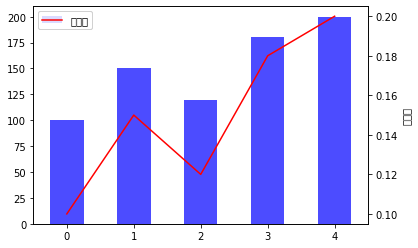

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# 创建示例数据
data = {'月份': ['一月', '二月', '三月', '四月', '五月'],
        '销售额': [100, 150, 120, 180, 200],}
data2={'利润率': [0.1, 0.15, 0.12, 0.18, 0.2]}
df = pd.DataFrame(data)
df2 = pd.DataFrame(data2)

# 绘制柱状图
df.plot(kind='bar', color='blue', alpha=0.7)

# 创建第二个y轴
ax2 = df2.iloc[:,0].plot(secondary_y=True, color='red')

# 设置坐标轴标签
plt.ylabel('销售额')
ax2.set_ylabel('利润率')

# 设置图例
plt.legend(['销售额', '利润率'])

# 显示图形
plt.show()
